In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
import pickle

# URLs for each CSV file in your GitHub repository
urls = {
    'AM_and_winger_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Attacking%20Midfielders%20and%20Wingers/Attacking%20Mid%20and%20Winger%20Role%20Scores.csv',
    'RB_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Right%20Backs/Right%20Back%20Role%20Scores.csv',
    'CB_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Center%20Backs/Center%20Back%20Role%20Scores.csv',
    'FW_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Forwards/Forward%20Role%20Scores.csv',
    'LB_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Left%20Backs/Left%20Back%20Role%20Scores.csv',
    'CM_scores': 'https://raw.githubusercontent.com/Jbuck1016/Player-Recommendation-System/main/Player%20Metrics/Center%20Midfielders/Center%20Midfielder%20Role%20Scores.csv'
}

# Load each CSV file from the URL
dataframes = {position: pd.read_csv(url) for position, url in urls.items()}

# Function to identify metric columns containing 'score'
def identify_metric_columns(df):
    return [col for col in df.columns if 'Score' in col or 'score' in col]

# Function to normalize player metrics
def normalize_player_metrics(df, metric_columns):
    scaler = MinMaxScaler()
    df_normalized = df.copy()
    df_normalized[metric_columns] = scaler.fit_transform(df[metric_columns])
    return df_normalized

# Function to calculate the similarity matrix
def calculate_similarity_matrix(df_normalized, metric_columns):
    distance_matrix = distance.cdist(df_normalized[metric_columns], df_normalized[metric_columns], 'euclidean')
    similarity_scores = 100 * (1 - (distance_matrix / distance_matrix.max()))
    similarity_df = pd.DataFrame(similarity_scores, index=df_normalized.index, columns=df_normalized.index)
    return similarity_df

# Process each positional DataFrame
normalized_dataframes = {}
similarity_matrices = {}

for position, df in dataframes.items():
    # Set index to player names
    df.set_index('player', inplace=True)
    
    # Identify metric columns
    metric_columns = identify_metric_columns(df)
    
    # Handle missing values
    df = df.dropna(subset=metric_columns)
    
    # Normalize the player metrics
    normalized_df = normalize_player_metrics(df, metric_columns)
    normalized_dataframes[position] = normalized_df
    
    # Calculate the player similarity
    player_similarity = calculate_similarity_matrix(normalized_df, metric_columns)
    similarity_matrices[position] = player_similarity

# Save the processed data and similarity matrices
with open('normalized_dataframes.pkl', 'wb') as f:
    pickle.dump(normalized_dataframes, f)

with open('similarity_matrices.pkl', 'wb') as f:
    pickle.dump(similarity_matrices, f)


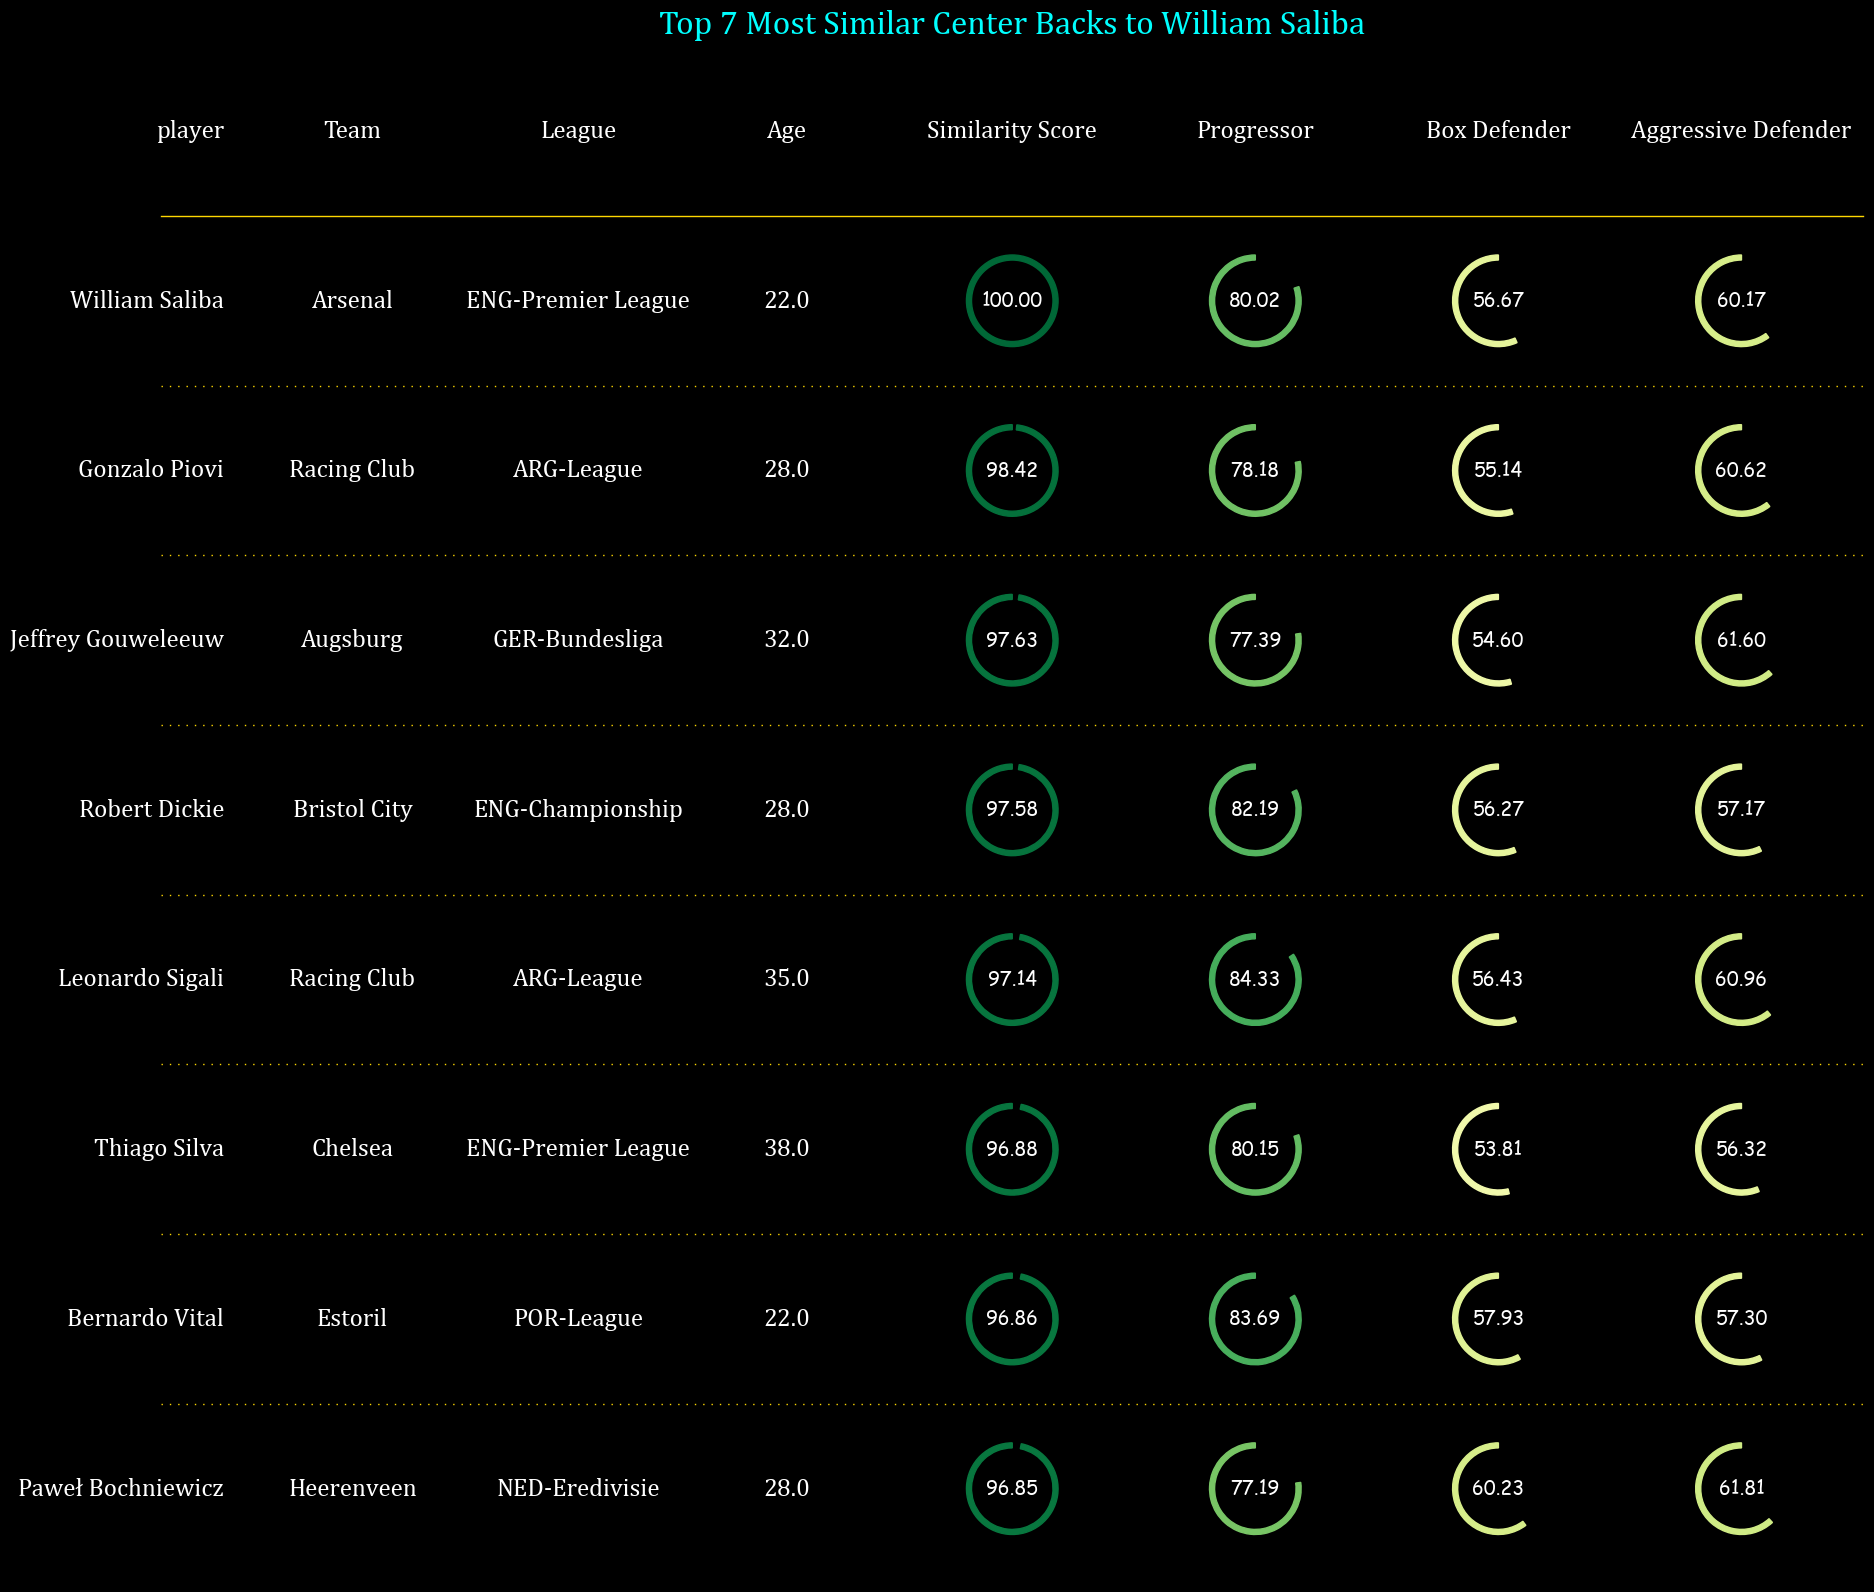

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import get_cmap
from plottable import Table, ColumnDefinition
from plottable.plots import progress_donut
import pickle

# Load the processed data and similarity matrices
with open('normalized_dataframes.pkl', 'rb') as f:
    normalized_dataframes = pickle.load(f)

with open('similarity_matrices.pkl', 'rb') as f:
    similarity_matrices = pickle.load(f)

# Function to identify metric columns containing 'Score'
def identify_metric_columns(df):
    return [col for col in df.columns if 'Score' in col or 'score' in col]

# Function to format column names
def format_column_name(col):
    if col.lower() == 'similarity score':
        return 'Similarity Score'
    if 'score' in col.lower():
        col = col.lower().replace('score', '').replace('_', ' ').strip()
        return ' '.join([word.capitalize() for word in col.split()])
    return ' '.join([word.capitalize() for word in col.split('_')])

# Position mapping dictionary
position_mapping = {
    'rb': 'Right Backs',
    'lb': 'Left Backs',
    'cb': 'Center Backs',
    'cm': 'Center Mids',
    'am and winger': 'Attacking Mids and Wingers',
    'fw': 'Forwards'
}

# Function to map position to full name
def map_position(position):
    position = position.replace('_scores', '').replace('_', ' ').lower()
    return position_mapping.get(position, position.title())

# Function to find the player and create the table
def create_similarity_table(player_name):
    common_columns = ["Team", "League", "Age", "Similarity Score"]
    
    found = False
    for position, df in normalized_dataframes.items():
        if player_name in df.index:
            found = True
            similarity_matrix = similarity_matrices[position]
            player_details_df = df
            
            # Extract similarity scores for the specified player
            player_similarity = similarity_matrix.loc[player_name].drop(player_name)
            top_similar = player_similarity.nlargest(7)

            # Fetch details for the top similar players
            top_details = player_details_df.loc[top_similar.index]
            top_details["Similarity"] = top_similar.values

            # Add the player himself to the top_details DataFrame
            player_row = player_details_df.loc[[player_name]].copy()
            player_row["Similarity"] = 100.0  # Maximum similarity for the player himself
            top_details = pd.concat([player_row, top_details])

            # Round all decimal values to 4 decimal places
            top_details = top_details.round(4)
            score_columns = identify_metric_columns(player_details_df)
            top_details[score_columns] = top_details[score_columns] * 100
            top_details["Similarity"] = top_details["Similarity"].round(2)  # Round Similarity Score to 2 decimal places

            # Rename the columns
            top_details.rename(columns={
                "team": "Team",
                "league": "League",
                "Similarity": "Similarity Score",
                "age": "Age"
            }, inplace=True)

            # Ensure the columns are ordered correctly
            final_columns = common_columns + score_columns
            top_details = top_details[final_columns]

            # Format the column names
            top_details.columns = [format_column_name(col) for col in top_details.columns]

            # Function to get color based on value
            def get_color(val):
                cmap = plt.get_cmap('RdYlGn')
                norm = Normalize(vmin=0, vmax=100)
                return cmap(norm(val))

            # Custom function to format the displayed text
            def formatted_progress_donut(ax, val, **kwargs):
                return progress_donut(ax, val, color=get_color(val), is_pct=False, textprops={'color': 'white', 'fontsize': 14, 'fontname': 'Comic Sans MS'}, formatter="{:.2f}".format(val))

            # Update column definitions to include color mapping for the progress donuts
            col_defs = [
                ColumnDefinition(name="Team", textprops={"ha": "center"}, width=3.5),
                ColumnDefinition(name="League", textprops={"ha": "center"}, width=3),
                ColumnDefinition(name="Age", textprops={"ha": "center"}, width=3),
                ColumnDefinition(name="Similarity Score", plot_fn=formatted_progress_donut, textprops={"ha": "center"}, width=3.5),
            ]
            
            for score_column in score_columns:
                formatted_score_column = format_column_name(score_column)
                col_defs.append(ColumnDefinition(name=formatted_score_column, plot_fn=formatted_progress_donut, textprops={"ha": "center"}, width=3.5))

            # Create the plot
            fig, ax = plt.subplots(figsize=(22, 20))
            fig.patch.set_facecolor('black')  # Set figure background color to black
            ax.set_facecolor('black') 

            # Add title to the plot
            full_position_name = map_position(position)
            plt.title(f"Top 7 Most Similar {full_position_name} to {player_name}", color='cyan', fontsize=24, fontname='Cambria')

            # Create and style the table using plottable
            table = Table(
                top_details,
                column_definitions=col_defs,
                row_dividers=True,
                footer_divider=True,
                ax=ax,
                textprops={"fontsize": 18, "color": "white", 'fontname': 'Cambria'},  # Set text color to white
                row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5)), "color": "gold"},
                col_label_divider_kw={"linewidth": 1, "linestyle": "-", "color": "gold"},
                column_border_kw={"linewidth": 1, "linestyle": "-", "color": "gold"},
            )

            # Show the plot
            plt.show()
            break
    if not found:
        print(f"Player {player_name} not found in any positional DataFrame.")

# Example usage
create_similarity_table("William Saliba")


In [4]:
normalized_dataframes

{'AM_and_winger_scores':                                 team              league  Wide Creator Score  \
 player                                                                         
 Bukayo Saka                  Arsenal  ENG-Premier League            0.752606   
 Gabriel Martinelli           Arsenal  ENG-Premier League            0.581103   
 Kai Havertz                  Arsenal  ENG-Premier League            0.541215   
 Leandro Trossard             Arsenal  ENG-Premier League            0.549325   
 Martin Ødegaard              Arsenal  ENG-Premier League            0.747842   
 ...                              ...                 ...                 ...   
 Elías Cabrera        Vélez Sarsfield          ARG-League            0.820952   
 Gianluca Prestianni  Vélez Sarsfield          ARG-League            0.724987   
 Julián Fernández     Vélez Sarsfield          ARG-League            0.525764   
 Lucas Janson         Vélez Sarsfield          ARG-League            0.334016   
 Wal